In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers 
from keras.models import Model, load_model 
import pandas as pd
from tensorflow.keras.optimizers import RMSprop

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 훈련데이터는 10000개, 검증 데이터는 2000개만 사용
x_train, x_test = x_train[:10000] / 255.0, x_test[:2000] / 255.0
y_train, y_test = y_train[:10000], y_test[:2000]

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
x_train_preprocess = np.zeros((x_train.shape[0], 75, 75, 3), 
                              dtype=np.float32)
print(x_train_preprocess.shape)
# 훈련 데이터 각각의 크기를 75x75로 변형 (인셉션 모델의 최소 크기)
for i, img in enumerate(x_train):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_train_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(10000, 75, 75, 3)


In [7]:
x_test_preprocess = np.zeros((x_test.shape[0], 75, 75, 3), 
                             dtype=np.float32)
print(x_test_preprocess.shape)
# 검증 데이터 각각의 크기를 75x75로 변형 (인셉션모델 최소 입력 크기)
for i, img in enumerate(x_test):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_test_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(2000, 75, 75, 3)


In [8]:
#인셉션 v3모델을 가져옴. 입력은 (75,75,3)의 크기 include_top은 false, 임의의 난수값으로 가중치 초기화
pre_trained_model = InceptionV3(input_shape=(75, 75, 3), 
                              include_top=False,
                              weights=None)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [15]:
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
#인셉션 v3모델을 mixed10까지 사용하기로 결정 이 계층의 출력을 펼쳐서 입력으로 하는 은닉층 생성
#2개 은닉층(노드 1024, 노드 512)을 추가하고 출력층의 활성화 함수로 softmax 함수를 사용하여 CNN 인공신경망을 재설계
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

In [17]:
model = Model(pre_trained_model.input, x)
#인셉션 v3모델의 일부와 새로운 계층들을 연결해 모델 생성
#케라스 Model을 생성하면서 둘을 나열함
model.compile(optimizer=RMSprop(lr=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


20 에폭으로 모델 학습.

In [18]:
history = model.fit(x_train_preprocess, y_train, epochs=20, 
                    validation_data=(x_test_preprocess, y_test))

Epoch 1/20
313/313 [==============================] - 758s 2s/step - loss: 0.6660 - accuracy: 0.8406 - val_loss: 10.1697 - val_accuracy: 0.7240
Epoch 2/20
313/313 [==============================] - 742s 2s/step - loss: 0.3665 - accuracy: 0.9257 - val_loss: 3.1995 - val_accuracy: 0.8575
Epoch 3/20
313/313 [==============================] - 741s 2s/step - loss: 0.2480 - accuracy: 0.9514 - val_loss: 0.3957 - val_accuracy: 0.9155
Epoch 4/20
313/313 [==============================] - 744s 2s/step - loss: 0.2318 - accuracy: 0.9593 - val_loss: 0.7701 - val_accuracy: 0.8560
Epoch 5/20
313/313 [==============================] - 743s 2s/step - loss: 0.2004 - accuracy: 0.9658 - val_loss: 0.3725 - val_accuracy: 0.9490
Epoch 6/20
313/313 [==============================] - 744s 2s/step - loss: 0.1859 - accuracy: 0.9632 - val_loss: 0.2183 - val_accuracy: 0.9640
Epoch 7/20
313/313 [==============================] - 744s 2s/step - loss: 0.1760 - accuracy: 0.9678 - val_loss: 0.2101 - val_accuracy: 0.972

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#훈련과정에서 모델이 보인 예측 정확도와 손실 값을 확인하기 위해 값들을 얻어옴
epochs = range(len(acc))

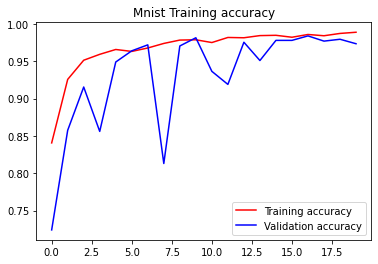

<Figure size 432x288 with 0 Axes>

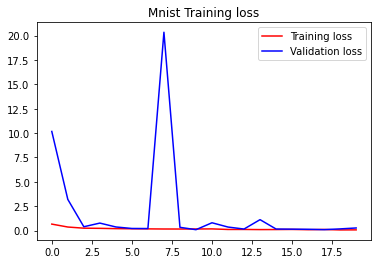

<Figure size 432x288 with 0 Axes>

In [20]:
#훈련 과정의 정확도와 손실을 화면에 그려봄
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Mnist Training accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Mnist Training loss")
plt.legend(loc=0)
plt.figure()
plt.show()